<a href="https://colab.research.google.com/github/Serap98/CNN/blob/main/VSER_individual_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
from google.colab import drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [39]:
import os
os.getcwd()

'/content/gdrive/My Drive/content'

In [40]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/content/"

In [41]:
#changing the working directory
%cd /content/gdrive/My Drive/content
#Check the present working directory using pwd command

/content/gdrive/My Drive/content


In [ ]:
!kaggle datasets download -d carlolepelaars/camseq-semantic-segmentation

 96% 87.0M/90.3M [00:00<00:00, 132MB/s] 
100% 90.3M/90.3M [00:00<00:00, 120MB/s]


In [ ]:
import zipfile
path_to_zip = 'camseq-semantic-segmentation.zip'
directory_to_extract_to = 'individual_work//'
with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [64]:
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path


def load_image_data(dataset_path, new_image_size=(124, 124)):
    image_mask_filepaths = list(image_path.glob('*[L].png'))
    image_filepaths = map(lambda x: Path(f'{dataset_path.parts[0]}/{x.name[:-6]}.png'), image_mask_filepaths)
    change_size = lambda img: img.resize(new_image_size)
    images = map(lambda x: np.array(change_size(Image.open(x))), image_filepaths)
    masks = map(lambda x: np.array(change_size(Image.open(x))), image_mask_filepaths)
    return np.array(list(images)), np.array(list(masks))




In [65]:
image_path = Path('individual_work')
NEW_SIZE = (256, 256)
images, masks = load_image_data(image_path, new_image_size=NEW_SIZE)



Loaded image array shape: (101, 256, 256, 3)


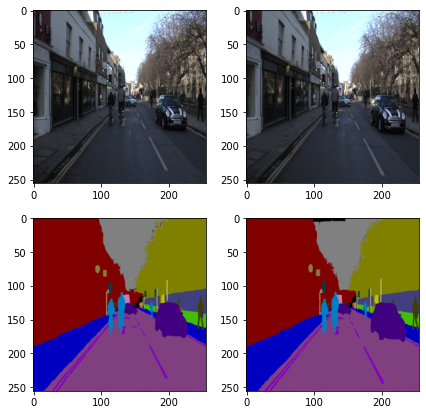

In [88]:
import matplotlib.pyplot as plt

print(f'Loaded image array shape: {np.array(images).shape}')

f, ax = plt.subplots(2, 2, figsize=(7, 7))

ax[0, 0].imshow(images[0])
ax[0, 1].imshow(images[1])
ax[1, 0].imshow(masks[0])
ax[1, 1].imshow(masks[1])


## Color codes taken from https://mi.eng.cam.ac.uk/research/projects/VideoRec/CamSeq01/

In [66]:

def create_mask_channels(mask, color_codes, get_one_hot=False):
    number_of_channels = len(color_codes.keys())  # N_CLASSES
    mask_channels = np.zeros((mask.shape[0], mask.shape[1],
                              number_of_channels), 
                             dtype=np.float32)
    for i, cls in enumerate(color_codes.keys()):
        color = color_codes[cls]
        multiplier = 1 if get_one_hot else i
        sub_mask = np.all(mask==color, axis=-1) * multiplier
        mask_channels[:, :, i] = sub_mask
    return mask_channels




color_codes = {
    'Animal': [64, 128, 64],
    'Archway': [192, 0, 128],
    'Bicyclist': [0, 128, 192],
    'Building': [128, 0, 0],
    'Car': [64, 0, 128],
    'CartLuggagePram': [64, 0, 192],
    'Child': [192, 128, 64], 
    'Column_Pole': [192, 192, 128],
    'Fence': [64, 64, 128],
    'LaneMkgsDriv': [128, 0, 192],
    'Misc_Text': [128, 128, 64],
    'OtherMoving': [128, 64, 64],
    'Pedestrian': [64, 64, 0],
    'Road': [128, 64, 128],
    'Sidewalk': [0, 0, 192],
    'SignSymbol': [192, 128, 128],
    'Sky': [128, 128, 128],
    'TrafficLight': [0, 64, 64],
    'Tree': [128, 128, 0],
    'Truck_Bus': [192, 128, 192],
    'VegetationMisc': [192, 192, 0],
    'Void': [0, 0, 0],
    'Wall': [64, 192, 0]
}

masks_cats = list(map(lambda x: create_mask_channels(x, color_codes, False), masks))

masks_one_hot = list(map(lambda x: create_mask_channels(x, color_codes, True), masks))

In [52]:
images.shape

(101, 256, 256, 3)

In [67]:
from sklearn.utils import class_weight

# check data balance and create weithts in case of disbalance
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(masks_cats),
                                                  y=np.array(masks_cats).reshape(-1))      
# get class names and weights
dict_of_classes = {}
for i, j in enumerate(color_codes.keys()):
    try:
        dict_of_classes[j] = class_weights[i]
    except:
        continue
# look at classes and their weights
dict_of_classes

{'Animal': 0.045164106437336614,
 'Archway': 79748.6265060241,
 'Bicyclist': 72.90279093332158,
 'Building': 4.342971570819032,
 'Car': 78.75610974942293,
 'CartLuggagePram': 287788.52173913043,
 'Child': 8574.0103626943,
 'Column_Pole': 10326.265210608424,
 'Fence': 43.97395764130637,
 'LaneMkgsDriv': 371.6945193171608,
 'Misc_Text': 787.6173250832936,
 'OtherMoving': 306.48404871046904,
 'Pedestrian': 344.11936573953733,
 'Road': 4.125097765737402,
 'Sidewalk': 13.25470783771877,
 'SignSymbol': 4392.2601194426015,
 'Sky': 12.297740784780023,
 'TrafficLight': 332.0858920329119,
 'Tree': 6.567789025399427,
 'Truck_Bus': 617.2839690385154,
 'VegetationMisc': 2383.556355779618,
 'Void': 247.46283834305368,
 'Wall': 125.05925030229746}

In [68]:
images = list(map(lambda x: x / 255.0, images))
masks = list(map(lambda x: x / 255.0, masks))

In [69]:
print(f'Number of classes: {len(color_codes.keys())}')

Number of classes: 23


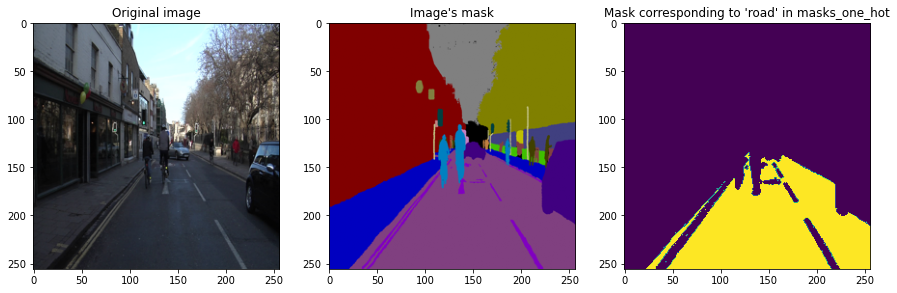

In [70]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import io
import cv2
import matplotlib
import random

import warnings
warnings.filterwarnings('ignore')

matplotlib.pyplot.rcParams['figure.figsize'] = (10,5)



plt.figure(figsize=(15, 10))
plt.subplot(1,3,1)
plt.imshow(images[7])
plt.title('Original image')
plt.subplot(1,3,2)
plt.imshow(masks[7])
plt.title("Image's mask")
plt.subplot(1,3,3)
plt.imshow(masks_one_hot[7][:, :, 13]) ## road
plt.title("Mask corresponding to 'road' in masks_one_hot")
plt.show()


In [71]:
from sklearn.model_selection import train_test_split

# split data on train/val/test sets
x_train, x_valtest, y_train, y_valtest = train_test_split(
    images, masks_one_hot, test_size=0.2, random_state=42, shuffle=True)
x_val, x_test, y_val, y_test = train_test_split(
    x_valtest, y_valtest, test_size=0.2, random_state=42, shuffle=False)

print('Training set: {}\nValidation set: {}\nTesting set: {}'.format(
    (len(x_train), len(y_train)), (len(x_val), len(y_val)), (len(x_test), len(y_test))))

Training set: (80, 80)
Validation set: (16, 16)
Testing set: (5, 5)


In [72]:
# just sanity check of data again before training model
x_train[0].min(), y_train[0].min(), x_train[0].max(), y_train[0].max()

(0.011764705882352941, 0.0, 1.0, 1.0)

In [73]:
# build unet model for multiclass case

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ReLU
from keras.layers import Conv2DTranspose, BatchNormalization, Dropout, Lambda


KERNEL = kernel = tf.keras.initializers.HeNormal()

def multi_unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    # Encoder
    c1 = Conv2D(64, (3, 3), padding='same', kernel_initializer=KERNEL)(inputs)
    c1 = ReLU()(c1)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, (3, 3), padding='same', kernel_initializer=KERNEL)(c1)
    c1 = BatchNormalization()(c1)
    c1 = ReLU()(c1)
    p1 = MaxPooling2D((2, 2), strides=2)(c1)

    c2 = Conv2D(128, (3, 3), padding='same', kernel_initializer=KERNEL)(p1)
    c2 = ReLU()(c2)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3, 3), padding='same', kernel_initializer=KERNEL)(c2)
    c2 = BatchNormalization()(c2)
    c2 = ReLU()(c2)
    p2 = MaxPooling2D((2, 2), strides=2)(c2)
     
    c3 = Conv2D(256, (3, 3), padding='same', kernel_initializer=KERNEL)(p2)
    c3 = ReLU()(c3)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3, 3), padding='same', kernel_initializer=KERNEL)(c3)
    c3 = ReLU()(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2), strides=2)(c3)
     
    c4 = Conv2D(512, (3, 3), padding='same', kernel_initializer=KERNEL)(p3)
    c4 = ReLU()(c4)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512, (3, 3), padding='same', kernel_initializer=KERNEL)(c4)
    c4 = ReLU()(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2), strides=2)(c4)
     
    c5 = Conv2D(1024, (3, 3), padding='same', kernel_initializer=KERNEL)(p4)
    c5 = ReLU()(c5)
    c5 = BatchNormalization()(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=2, padding='same')(c5)
    u6 = tf.concat([c4, u6], axis=3)
    c6 = Conv2D(512, (3, 3), padding='same', kernel_initializer=KERNEL)(u6)
    c6 = ReLU()(c6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(512, (3, 3), padding='same', kernel_initializer=KERNEL)(c6)
    c6 = ReLU()(c6)
    c6 = BatchNormalization()(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=2, padding='same')(c6)
    u7 = tf.concat([c3, u7], axis=3)
    c7 = Conv2D(256, (3, 3), padding='same', kernel_initializer=KERNEL)(u7)
    c7 = ReLU()(c7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(256, (3, 3), padding='same', kernel_initializer=KERNEL)(c7)
    c7 = ReLU()(c7)
    c7 = BatchNormalization()(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=2, padding='same')(c7)
    u8 = tf.concat([u8, c2], axis=3)
    c8 = Conv2D(128, (3, 3), padding='same', kernel_initializer=KERNEL)(u8)
    c8 = ReLU()(c8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(128, (3, 3), padding='same', kernel_initializer=KERNEL)(c8)
    c8 = ReLU()(c8)
    c8 = BatchNormalization()(c8)
    
    u9 = Conv2DTranspose(64, (2, 2), strides=2, padding='same')(c8)
    u9 = tf.concat([c1, u9], axis=3)
    c9 = Conv2D(64, (3, 3), padding='same', kernel_initializer=KERNEL)(u9)
    c9 = ReLU()(c9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(64, (3, 3), padding='same', kernel_initializer=KERNEL)(c9)
    c9 = ReLU()(c9)
    c9 = BatchNormalization()(c9)

    # set outputs
    outputs = Conv2D(N_CLASSES, (1, 1), activation='softmax')(c9)
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [74]:
# declare the model and compile it
N_CLASSES = len(color_codes.keys())

model = multi_unet(
    IMG_HEIGHT=NEW_SIZE[0], IMG_WIDTH=NEW_SIZE[1], IMG_CHANNELS=3,  N_CLASSES=N_CLASSES
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_54 (Conv2D)             (None, 256, 256, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 re_lu_51 (ReLU)                (None, 256, 256, 64  0           ['conv2d_54[0][0]']              
                                )                                                           

In [75]:
EPOCHS = 100
BATCH_SIZE = 32  # according to the original paper

history = model.fit(np.array(x_train), np.array(y_train),
                    validation_data=(np.array(x_val), np.array(y_val)), 
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=2)

Epoch 1/100
3/3 - 7s - loss: 2.5948 - accuracy: 0.1920 - val_loss: 2.8068 - val_accuracy: 0.0728 - 7s/epoch - 2s/step
Epoch 2/100
3/3 - 4s - loss: 1.5411 - accuracy: 0.4927 - val_loss: 3.2915 - val_accuracy: 0.0812 - 4s/epoch - 1s/step
Epoch 3/100
3/3 - 4s - loss: 1.0293 - accuracy: 0.6431 - val_loss: 8.0114 - val_accuracy: 0.2288 - 4s/epoch - 1s/step
Epoch 4/100
3/3 - 4s - loss: 0.7082 - accuracy: 0.7290 - val_loss: 26.0242 - val_accuracy: 0.2365 - 4s/epoch - 1s/step
Epoch 5/100
3/3 - 4s - loss: 0.5637 - accuracy: 0.7490 - val_loss: 77.4984 - val_accuracy: 0.2378 - 4s/epoch - 1s/step
Epoch 6/100
3/3 - 4s - loss: 0.4663 - accuracy: 0.7707 - val_loss: 83.1906 - val_accuracy: 0.2378 - 4s/epoch - 1s/step
Epoch 7/100
3/3 - 4s - loss: 0.3971 - accuracy: 0.7838 - val_loss: 44.3850 - val_accuracy: 0.2318 - 4s/epoch - 1s/step
Epoch 8/100
3/3 - 4s - loss: 0.3633 - accuracy: 0.7899 - val_loss: 57.3782 - val_accuracy: 0.2298 - 4s/epoch - 1s/step
Epoch 9/100
3/3 - 4s - loss: 0.3367 - accuracy: 0.7

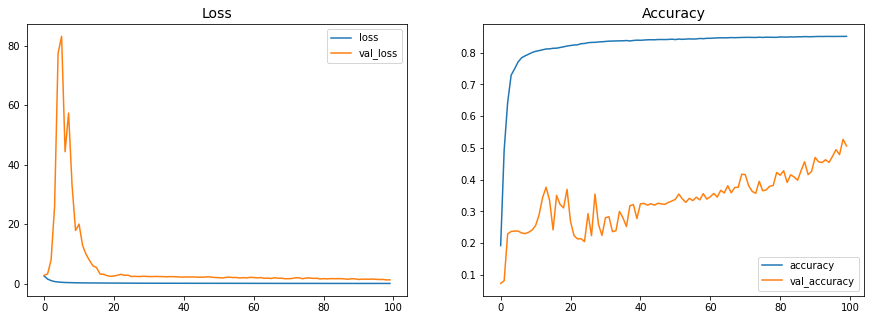

In [76]:
import seaborn as sns

loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epoch = range(0, EPOCHS)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.lineplot(epoch, loss)
sns.lineplot(epoch, val_loss)
plt.title('Loss', size=14)
plt.legend(['loss', 'val_loss'])
plt.subplot(1,2,2)
sns.lineplot(epoch, accuracy)
sns.lineplot(epoch, val_accuracy)
plt.title('Accuracy', size=14)
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [77]:
# make predictions

prediction = model.predict(np.array(x_test))

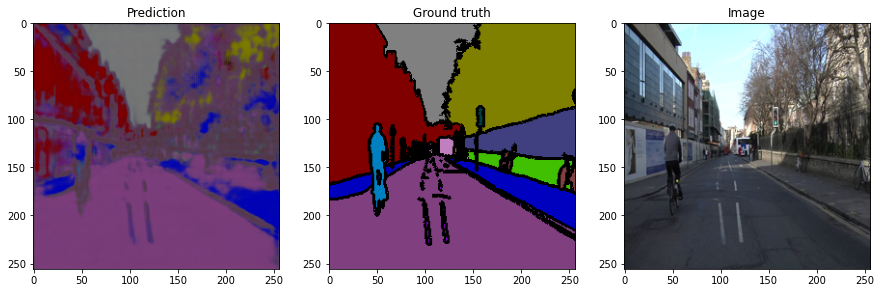

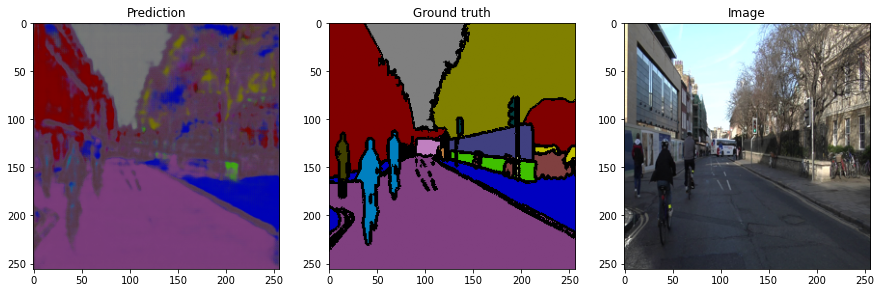

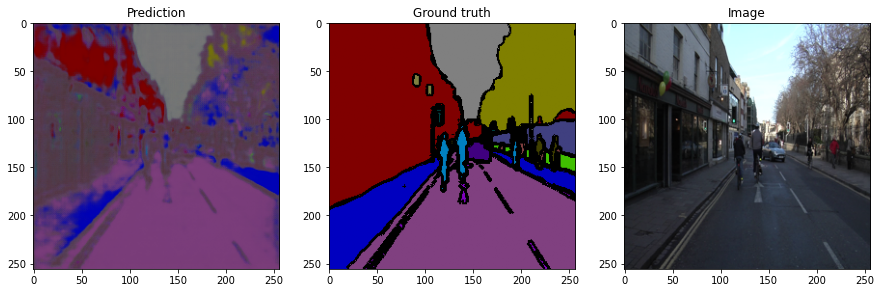

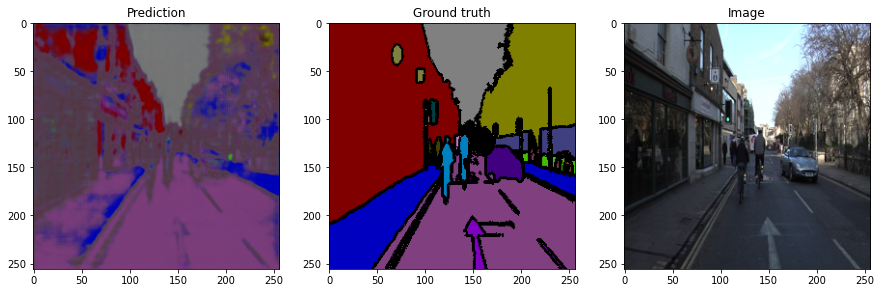

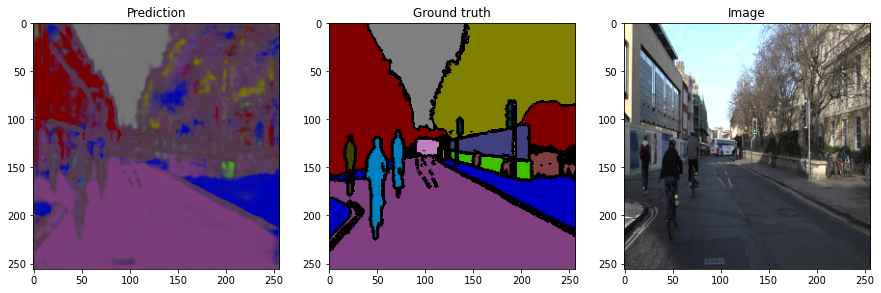

In [78]:
# get list of color codes 
color_codes_list = [color_codes[i] for i in color_codes.keys()]


def get_rgb_image(prediction, n_classes, color_codes):
    """Returns RGB image from predicted segmentation map"""
    output_height = prediction.shape[0]
    output_width = prediction.shape[1]
    seg_img = np.zeros((output_height, output_width, 3))
    for c in range(n_classes):
        seg_img[:, :, 0] += ((prediction[:, :, c])*(color_codes[c][0])).astype('uint8')
        seg_img[:, :, 1] += ((prediction[:, :, c])*(color_codes[c][1])).astype('uint8')
        seg_img[:, :, 2] += ((prediction[:, :, c])*(color_codes[c][2])).astype('uint8')
    return seg_img / 255.0


# Visualize prediction and ground truth
for i in range(len(x_test)):
    plt.figure(figsize=(15, 6))
    plt.subplot(1,3,1)
    plt.imshow(get_rgb_image(prediction[i], N_CLASSES, color_codes_list))
    plt.title('Prediction')
    plt.subplot(1,3,2)
    plt.imshow(get_rgb_image(y_test[i], N_CLASSES, color_codes_list))
    plt.title('Ground truth')
    plt.subplot(1,3,3)
    plt.imshow(x_test[i])
    plt.title('Image')  
    plt.show()
    

In [ ]:
from keras import backend as K


def weighted_CCE_loss(class_weights):
    """ Weighted crossentropy loss """
    def weighted_loss(y_true, y_pred):
        class_weights_tensor = tf.cast(class_weights, tf.float32)
        y_pred_weighted = y_pred * class_weights_tensor
        cce_loss = - K.sum(y_true * K.log(y_pred_weighted))
        return cce_loss
    return weighted_loss

In [80]:
from sklearn.utils import class_weight

# check data balance and create weithts in case of disbalance
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(masks_cats),
                                                  y=np.array(masks_cats).reshape(-1))      
# get class names and weights
dict_of_classes = {}
for i, j in enumerate(color_codes.keys()):
    try:
        dict_of_classes[j] = class_weights[i]
    except:
        continue
# look at classes and their weights
dict_of_classes

{'Animal': 0.045164106437336614,
 'Archway': 79748.6265060241,
 'Bicyclist': 72.90279093332158,
 'Building': 4.342971570819032,
 'Car': 78.75610974942293,
 'CartLuggagePram': 287788.52173913043,
 'Child': 8574.0103626943,
 'Column_Pole': 10326.265210608424,
 'Fence': 43.97395764130637,
 'LaneMkgsDriv': 371.6945193171608,
 'Misc_Text': 787.6173250832936,
 'OtherMoving': 306.48404871046904,
 'Pedestrian': 344.11936573953733,
 'Road': 4.125097765737402,
 'Sidewalk': 13.25470783771877,
 'SignSymbol': 4392.2601194426015,
 'Sky': 12.297740784780023,
 'TrafficLight': 332.0858920329119,
 'Tree': 6.567789025399427,
 'Truck_Bus': 617.2839690385154,
 'VegetationMisc': 2383.556355779618,
 'Void': 247.46283834305368,
 'Wall': 125.05925030229746}

In [81]:
np.unique(masks_cats)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22.], dtype=float32)

In [82]:
np.array(masks_cats).shape

(101, 256, 256, 23)

In [83]:
# declare the model and compile it

model1 = multi_unet(
    IMG_HEIGHT=NEW_SIZE[0], IMG_WIDTH=NEW_SIZE[1], IMG_CHANNELS=3,  N_CLASSES=N_CLASSES
)
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=weighted_CCE_loss(class_weights),
    metrics=['accuracy']
)
model1.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_72 (Conv2D)             (None, 256, 256, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 re_lu_68 (ReLU)                (None, 256, 256, 64  0           ['conv2d_72[0][0]']              
                                )                                                           

In [84]:
# And fun comes..!

EPOCHS = 100
BATCH_SIZE = 8

history = model1.fit(np.array(x_train), np.array(y_train),
                    validation_data=(np.array(x_val), np.array(y_val)), 
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=2)

Epoch 1/100
10/10 - 20s - loss: -7.7688e+04 - accuracy: 0.4758 - val_loss: nan - val_accuracy: 0.2374 - 20s/epoch - 2s/step
Epoch 2/100
10/10 - 5s - loss: -6.3722e+05 - accuracy: 0.7528 - val_loss: nan - val_accuracy: 0.2315 - 5s/epoch - 524ms/step
Epoch 3/100
10/10 - 5s - loss: -7.4801e+05 - accuracy: 0.7925 - val_loss: nan - val_accuracy: 0.2269 - 5s/epoch - 495ms/step
Epoch 4/100
10/10 - 5s - loss: -7.9002e+05 - accuracy: 0.8102 - val_loss: nan - val_accuracy: 0.3566 - 5s/epoch - 527ms/step
Epoch 5/100
10/10 - 5s - loss: -8.0955e+05 - accuracy: 0.8152 - val_loss: 1170005.2500 - val_accuracy: 0.3051 - 5s/epoch - 499ms/step
Epoch 6/100
10/10 - 5s - loss: -8.2563e+05 - accuracy: 0.8247 - val_loss: 409098.0938 - val_accuracy: 0.3818 - 5s/epoch - 531ms/step
Epoch 7/100
10/10 - 5s - loss: -8.3778e+05 - accuracy: 0.8308 - val_loss: 631665.5000 - val_accuracy: 0.2805 - 5s/epoch - 533ms/step
Epoch 8/100
10/10 - 5s - loss: -8.4760e+05 - accuracy: 0.8351 - val_loss: 630680.1250 - val_accuracy:

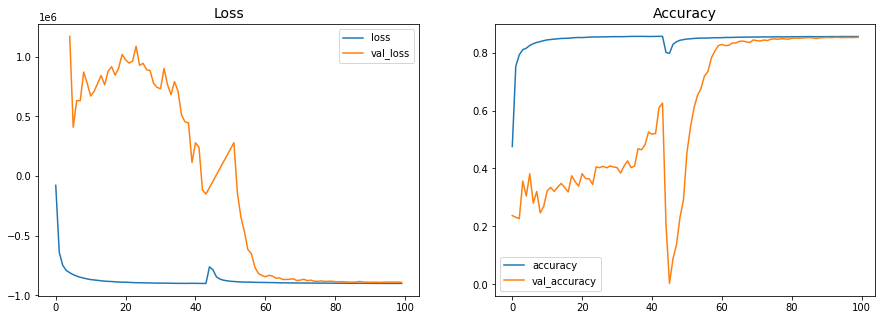

In [85]:
import seaborn as sns

loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epoch = range(0, EPOCHS)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.lineplot(epoch, loss)
sns.lineplot(epoch, val_loss)
plt.title('Loss', size=14)
plt.legend(['loss', 'val_loss'])
plt.subplot(1,2,2)
sns.lineplot(epoch, accuracy)
sns.lineplot(epoch, val_accuracy)
plt.title('Accuracy', size=14)
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

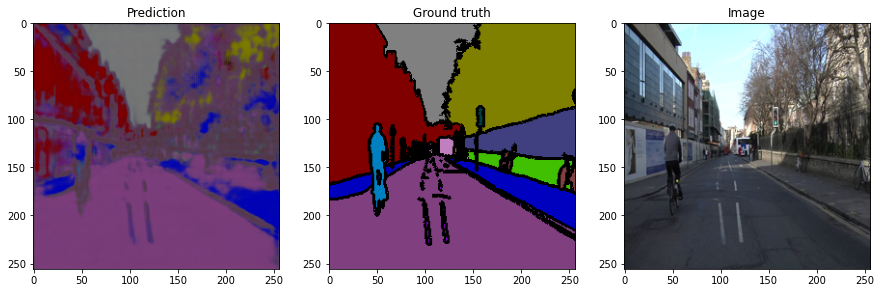

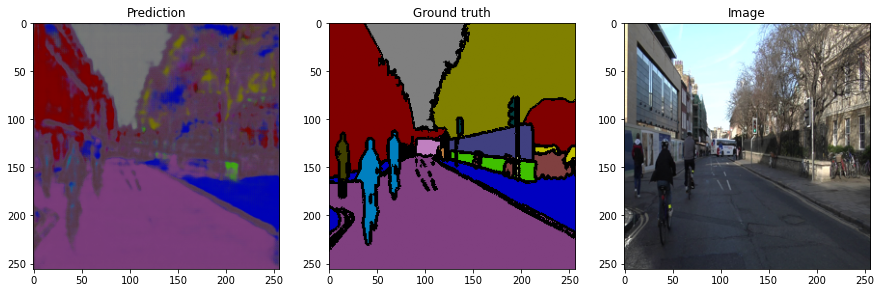

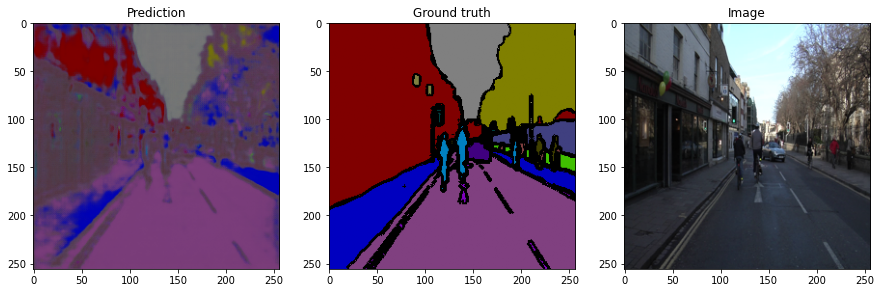

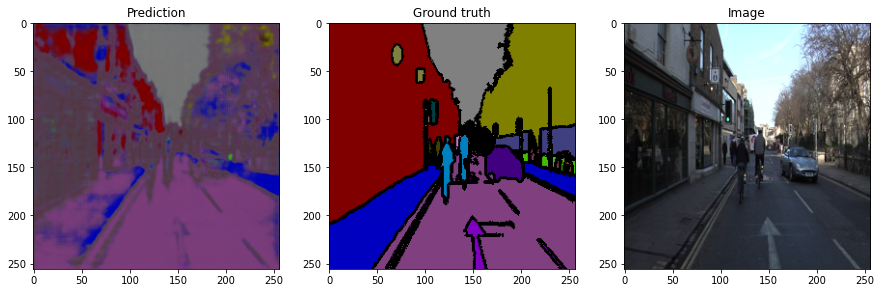

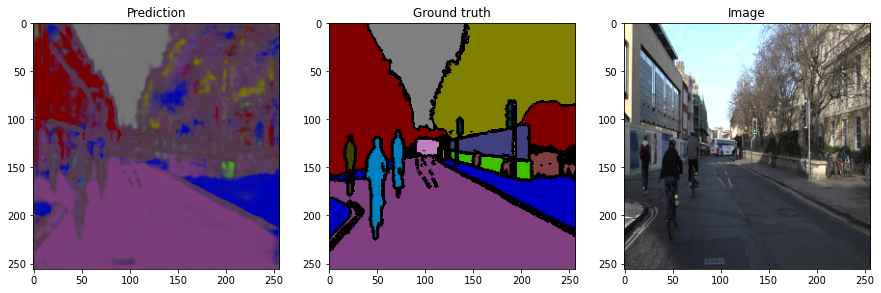

In [86]:
# get list of color codes 
color_codes_list = [color_codes[i] for i in color_codes.keys()]


def get_rgb_image(prediction, n_classes, color_codes):
    """Returns RGB image from predicted segmentation map"""
    output_height = prediction.shape[0]
    output_width = prediction.shape[1]
    seg_img = np.zeros((output_height, output_width, 3))
    for c in range(n_classes):
        seg_img[:, :, 0] += ((prediction[:, :, c])*(color_codes[c][0])).astype('uint8')
        seg_img[:, :, 1] += ((prediction[:, :, c])*(color_codes[c][1])).astype('uint8')
        seg_img[:, :, 2] += ((prediction[:, :, c])*(color_codes[c][2])).astype('uint8')
    return seg_img / 255.0


# Visualize prediction and ground truth
for i in range(len(x_test)):
    plt.figure(figsize=(15, 6))
    plt.subplot(1,3,1)
    plt.imshow(get_rgb_image(prediction[i], N_CLASSES, color_codes_list))
    plt.title('Prediction')
    plt.subplot(1,3,2)
    plt.imshow(get_rgb_image(y_test[i], N_CLASSES, color_codes_list))
    plt.title('Ground truth')
    plt.subplot(1,3,3)
    plt.imshow(x_test[i])
    plt.title('Image')  
    plt.show()
    